
CHARMM27 Analysis:
Using theta index: 200 (theta = 1.002308)
State C: 850 pure segments (>90.0% purity)
State E: 734 pure segments (>90.0% purity)
State NC: 1648 pure segments (>90.0% purity)
State N: 1492 pure segments (>90.0% purity)

Summary:
Total segments: 5000
Total pure segments: 4724
Mixed segments: 276
Mixed percentage: 5.5%

CHARMM36m Analysis:
Using theta index: 200 (theta = 1.002308)
State C: 257 pure segments (>90.0% purity)
State E: 4001 pure segments (>90.0% purity)
State NC: 11 pure segments (>90.0% purity)
State N: 508 pure segments (>90.0% purity)

Summary:
Total segments: 5000
Total pure segments: 4777
Mixed segments: 223
Mixed percentage: 4.5%


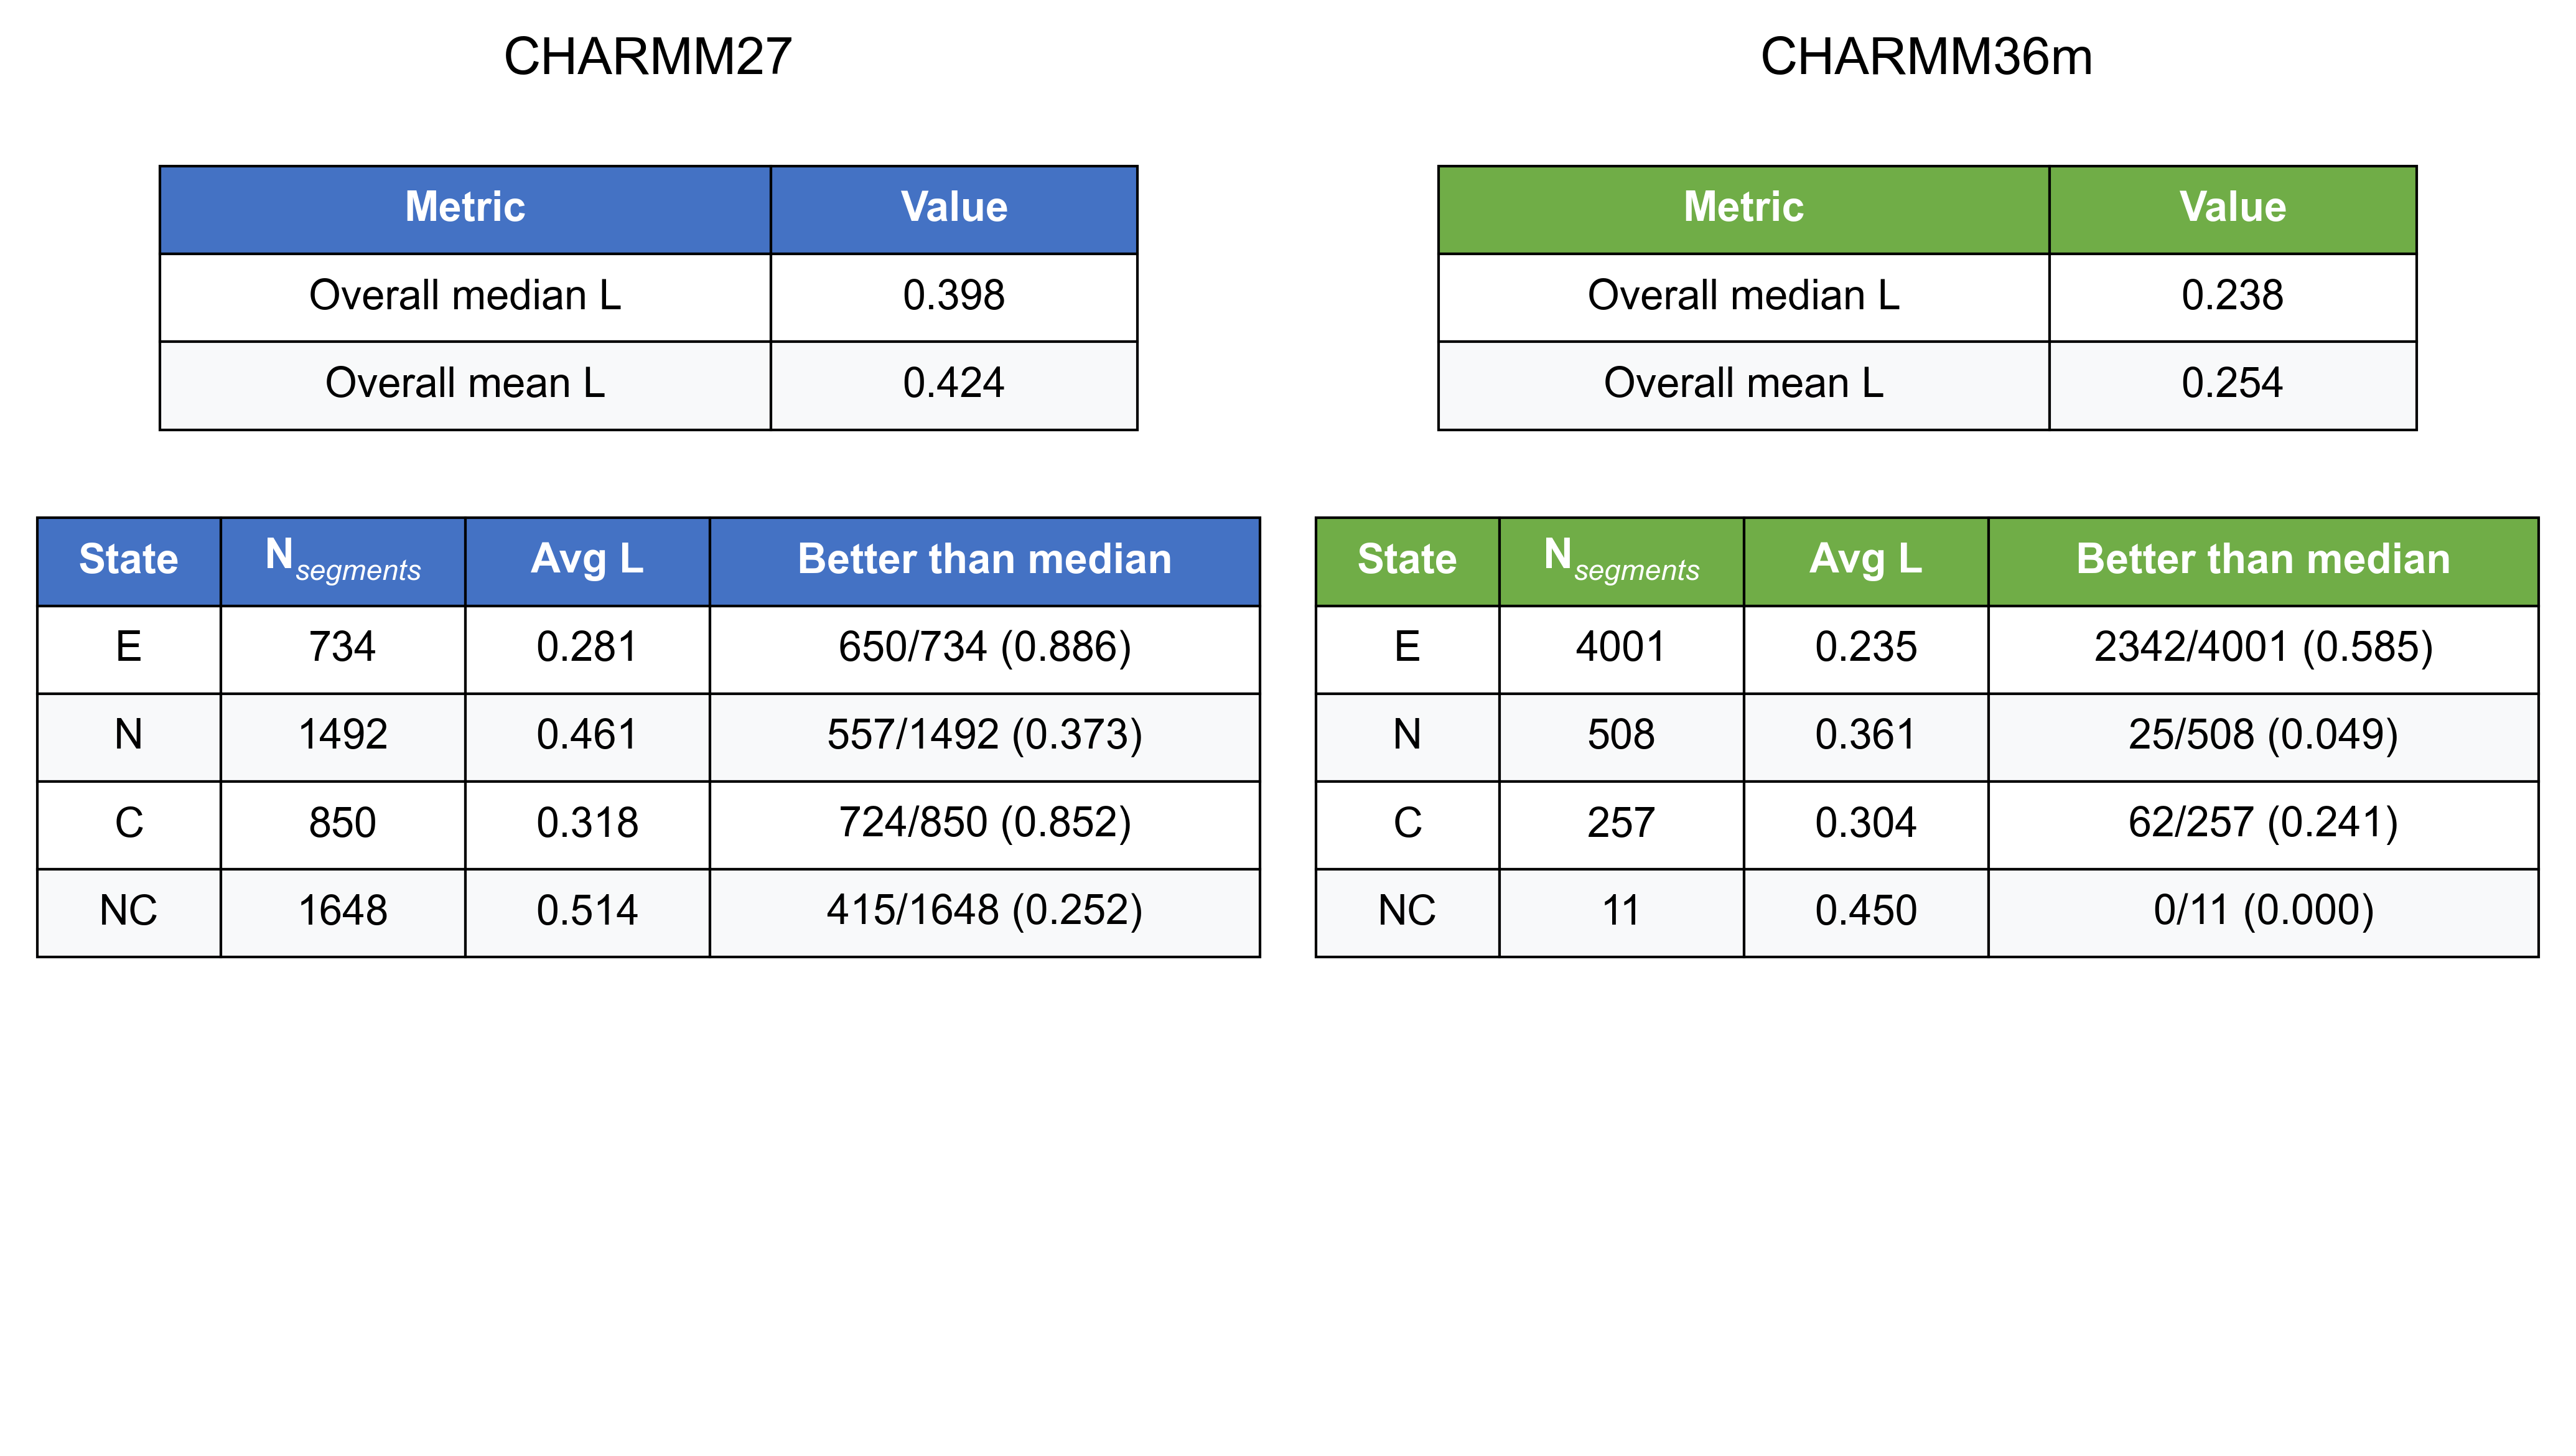

In [1]:
#!/usr/bin/env python
# coding: utf-8

### GENERATES STATE ANALYSIS TABLES FOR BOTH FORCE FIELDS ###

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# -----------------------------------------------------------------------------
# CONFIGURATION
# -----------------------------------------------------------------------------

# Paths
BASE_DIR = Path('../data')
PROP_DIR = BASE_DIR / 'prop_array'
ERROR_DIR = BASE_DIR / 'error_data' / 'overlap_full'

# Data Specifications
FORCE_FIELDS = ['CHARMM27_TIP3P', 'CHARMM36m_TIP3P']
FORCE_FIELD_LABELS = {
    'CHARMM27_TIP3P': 'CHARMM27',
    'CHARMM36m_TIP3P': 'CHARMM36m'
}
FORCE_FIELD_COLORS = {
    'CHARMM27_TIP3P': '#4472C4',
    'CHARMM36m_TIP3P': '#70AD47'
}

# Analysis Parameters
THETA_RANGE = np.logspace(-1, 4, 1000)  # 0.1 to 10000
REFERENCE_THETA = 1.0  # Extract L values at theta = 1
ISOTOPES = ['G3', 'G3+', 'G5+', 'G5+G3', 'V1', 'V1G3V4', 'V1V4', 'V4', 'WT']

# State definitions
STATE_KEYS = ['C', 'E', 'NC', 'N']
STATE_DISPLAY_ORDER = ['E', 'N', 'C', 'NC']
PURITY_THRESHOLD = 0.9

# Plotting Specifications
FIGURE_SIZE = (7, 4)
DPI = 600

# -----------------------------------------------------------------------------
# DATA LOADING
# -----------------------------------------------------------------------------

def load_proportions(force_field):
    """Load state proportions array for given force field."""
    filepath = PROP_DIR / force_field / f'proportions_array_0100ps_{force_field}_PAPER.npy'
    if not filepath.exists():
        raise FileNotFoundError(f"Proportions file not found: {filepath}")
    return np.load(filepath)

def load_l_values(force_field):
    """Load L values (sum of errors across isotopes at theta ≈ 1).
    
    The error files contain: error = (1 - overlap) * theta
    We extract values at theta ≈ 1 and divide by actual theta to get L = (1 - overlap).
    """
    # Find index closest to theta = 1
    theta_idx = np.argmin(np.abs(THETA_RANGE - REFERENCE_THETA))
    actual_theta = THETA_RANGE[theta_idx]
    
    # Sum error data across all isotopes at shift=0
    combined_l_values = None
    
    for isotope in ISOTOPES:
        filename = f'error_overlap_{isotope}_{force_field}_ch27_0.npy'
        filepath = ERROR_DIR / filename
        
        if filepath.exists():
            error_data = np.load(filepath)  # Shape: (5000, 1000)
            # Extract column at theta ≈ 1
            l_values_isotope = error_data[:, theta_idx]  # Shape: (5000,)
            
            if combined_l_values is None:
                combined_l_values = l_values_isotope
            else:
                combined_l_values = combined_l_values + l_values_isotope
        else:
            print(f"Warning: Missing file {filename}")
    
    if combined_l_values is None:
        raise ValueError(f"No error data found for {force_field}")
    
    # Divide by actual theta to get L = (1 - overlap)
    return combined_l_values / actual_theta  # Shape: (5000,) - L values for each segment

# -----------------------------------------------------------------------------
# ANALYSIS
# -----------------------------------------------------------------------------

def analyze_segments(proportions, l_values):
    """Analyze segments for purity and L value statistics."""
    n_segments = proportions.shape[0]
    
    # Calculate overall statistics
    median_l = np.median(l_values)
    mean_l = np.mean(l_values)
    
    # Analyze by state
    state_stats = {}
    for idx, state in enumerate(STATE_KEYS):
        # Find pure segments for this state
        pure_mask = proportions[:, idx] > PURITY_THRESHOLD
        n_pure = np.sum(pure_mask)
        
        if n_pure > 0:
            # L values for pure segments of this state
            state_l_values = l_values[pure_mask]
            avg_l = np.mean(state_l_values)
            better_than_median = np.sum(state_l_values < median_l)
            
            state_stats[state] = {
                'n_segments': n_pure,
                'avg_l': avg_l,
                'better_than_median': better_than_median,
                'fraction_better': better_than_median / n_pure
            }
        else:
            state_stats[state] = {
                'n_segments': 0,
                'avg_l': 0,
                'better_than_median': 0,
                'fraction_better': 0
            }
    
    # Calculate mixed segments
    max_proportions = np.max(proportions, axis=1)
    n_mixed = np.sum(max_proportions <= PURITY_THRESHOLD)
    mixed_percentage = (n_mixed / n_segments) * 100
    
    return {
        'overall': {'median_l': median_l, 'mean_l': mean_l},
        'states': state_stats,
        'mixed': {'count': n_mixed, 'percentage': mixed_percentage},
        'n_segments': n_segments
    }

# -----------------------------------------------------------------------------
# PLOTTING
# -----------------------------------------------------------------------------

def set_plot_style():
    """Set consistent plot style for ACS publication figures."""
    plt.rcParams.update({
        # Font settings - Arial (PC) or Helvetica (Mac) as per ACS
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'Helvetica'],
        'font.size': 10,  # Will be readable at 5pt when reduced to column width
        
        # Math text formatting
        'mathtext.fontset': 'custom',
        'mathtext.rm': 'Arial',
        'mathtext.it': 'Arial:italic',
        'mathtext.bf': 'Arial:bold',
        
        # Line widths - minimum 1 pt as per ACS
        'lines.linewidth': 1.0,
        'axes.linewidth': 1.0,
        'xtick.major.width': 1.0,
        'ytick.major.width': 1.0,
        'xtick.minor.width': 1.0,
        'ytick.minor.width': 1.0,
        'patch.linewidth': 1.0,
        'grid.linewidth': 1.0,
        
        # Font sizes - accounting for reduction
        'axes.labelsize': 11,
        'axes.titlesize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        
        # DPI settings
        'figure.dpi': DPI
    })

def create_table(ax, force_field, analysis_results, color):
    """Create analysis table for a force field."""
    ax.axis('tight')
    ax.axis('off')
    ax.set_title(FORCE_FIELD_LABELS[force_field], fontsize=10, pad=5, fontweight='normal')
    
    # Overall statistics table
    overall_data = [
        ['Metric', 'Value'],
        ['Overall median L', f"{analysis_results['overall']['median_l']:.3f}"],
        ['Overall mean L', f"{analysis_results['overall']['mean_l']:.3f}"]
    ]
    
    table_overall = ax.table(
        cellText=overall_data,
        loc='upper center',
        cellLoc='center',
        colWidths=[0.5, 0.3],
        bbox=[0.1, 0.75, 0.8, 0.2]
    )
    
    table_overall.auto_set_font_size(False)
    table_overall.set_fontsize(8)
    table_overall.scale(1, 1.2)
    
    # Style overall table
    for (i, j), cell in table_overall.get_celld().items():
        cell.set_linewidth(0.5)
        if i == 0:  # Header row
            cell.set_facecolor(color)
            cell.set_text_props(color='white', weight='bold')
        else:
            cell.set_facecolor('#F8F9FA' if i % 2 == 0 else 'white')
    
    # State analysis table
    state_headers = ['State', 'N$_{segments}$', 'Avg L', 'Better than median']
    state_data = []
    
    for state in STATE_DISPLAY_ORDER:
        stats = analysis_results['states'][state]
        if stats['n_segments'] > 0:
            state_data.append([
                state,
                str(stats['n_segments']),
                f"{stats['avg_l']:.3f}",
                f"{stats['better_than_median']}/{stats['n_segments']} ({stats['fraction_better']:.3f})"
            ])
    
    table_states = ax.table(
        cellText=[state_headers] + state_data,
        loc='lower center',
        cellLoc='center',
        colWidths=[0.15, 0.2, 0.2, 0.45],
        bbox=[0.0, 0.35, 1.0, 0.333]
    )
    
    table_states.auto_set_font_size(False)
    table_states.set_fontsize(8)
    table_states.scale(1, 1.2)
    
    # Style state table
    for (i, j), cell in table_states.get_celld().items():
        cell.set_linewidth(0.5)
        if i == 0:  # Header row
            cell.set_facecolor(color)
            cell.set_text_props(color='white', weight='bold')
        else:
            cell.set_facecolor('#F8F9FA' if i % 2 == 0 else 'white')
    
    # Print summary statistics
    actual_theta = THETA_RANGE[np.argmin(np.abs(THETA_RANGE - REFERENCE_THETA))]
    print(f"\n{FORCE_FIELD_LABELS[force_field]} Analysis:")
    print("=" * 40)
    print(f"Using theta index: {np.argmin(np.abs(THETA_RANGE - REFERENCE_THETA))} (theta = {actual_theta:.6f})")
    for state in STATE_KEYS:
        stats = analysis_results['states'][state]
        print(f"State {state}: {stats['n_segments']} pure segments (>{PURITY_THRESHOLD*100}% purity)")
    print(f"\nSummary:")
    print(f"Total segments: {analysis_results['n_segments']}")
    print(f"Total pure segments: {sum(s['n_segments'] for s in analysis_results['states'].values())}")
    print(f"Mixed segments: {analysis_results['mixed']['count']}")
    print(f"Mixed percentage: {analysis_results['mixed']['percentage']:.1f}%")

# -----------------------------------------------------------------------------
# MAIN
# -----------------------------------------------------------------------------

def main():
    """Main function to generate analysis tables."""
    set_plot_style()
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=FIGURE_SIZE, dpi=DPI)
    
    # Process each force field
    for idx, force_field in enumerate(FORCE_FIELDS):
        # Load data
        proportions = load_proportions(force_field)
        l_values = load_l_values(force_field)
        
        # Analyze
        results = analyze_segments(proportions, l_values)
        
        # Create table
        create_table(axes[idx], force_field, results, FORCE_FIELD_COLORS[force_field])
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()